In [1]:
import piplite

await piplite.install("vega_datasets")
await piplite.install("jinja2")
await piplite.install("bqplot")

In [2]:
from vega_datasets import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from js import fetch
import bqplot.pyplot as bqp
import bqplot as bq
import ipywidgets as w
from bqplot.interacts import BrushIntervalSelector

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 10)

/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
resp = await fetch(data.seattle_temps.url)
temps_txt = await resp.text()

In [4]:
resp_weather = await fetch(data.seattle_weather.url)
weather_txt = await resp_weather.text()

In [5]:
weather = pd.read_csv(StringIO(weather_txt))
weather

,date,precipitation,temp_max,temp_min,wind,weather
0,2012/01/01,0.0,12.8,5.0,4.7,drizzle
1,2012/01/02,10.9,10.6,2.8,4.5,rain
2,2012/01/03,0.8,11.7,7.2,2.3,rain
3,2012/01/04,20.3,12.2,5.6,4.7,rain
4,2012/01/05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015/12/27,8.6,4.4,1.7,2.9,fog
1457,2015/12/28,1.5,5.0,1.7,1.3,fog
1458,2015/12/29,0.0,7.2,0.6,2.6,fog
1459,2015/12/30,0.0,5.6,-1.0,3.4,sun


In [6]:
temps = pd.read_csv(StringIO(temps_txt))

temps = (
    temps.assign(date=lambda f: f["date"].pipe(pd.to_datetime))
    .set_index("date")
    .iloc[:, 0]
    .sub(32)
    .mul(5 / 9)
)

print("NaN values:", temps.resample("1h").mean().isna().loc[lambda s: s].index)

temps = temps.resample("1h").ffill()

print("After gap-filling: NaN values:", temps.isna().loc[lambda s: s].index)

temps

NaN values: DatetimeIndex(['2010-03-14 03:00:00'], dtype='datetime64[ns]', name='date', freq='H')
After gap-filling: NaN values: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq='H')


date
2010-01-01 00:00:00    4.111111
2010-01-01 01:00:00    4.000000
2010-01-01 02:00:00    3.888889
2010-01-01 03:00:00    3.833333
2010-01-01 04:00:00    3.777778
                         ...   
2010-12-31 19:00:00    4.833333
2010-12-31 20:00:00    4.722222
2010-12-31 21:00:00    4.555556
2010-12-31 22:00:00    4.444444
2010-12-31 23:00:00    4.222222
Freq: H, Name: temp, Length: 8760, dtype: float64

<AxesSubplot:xlabel='date'>

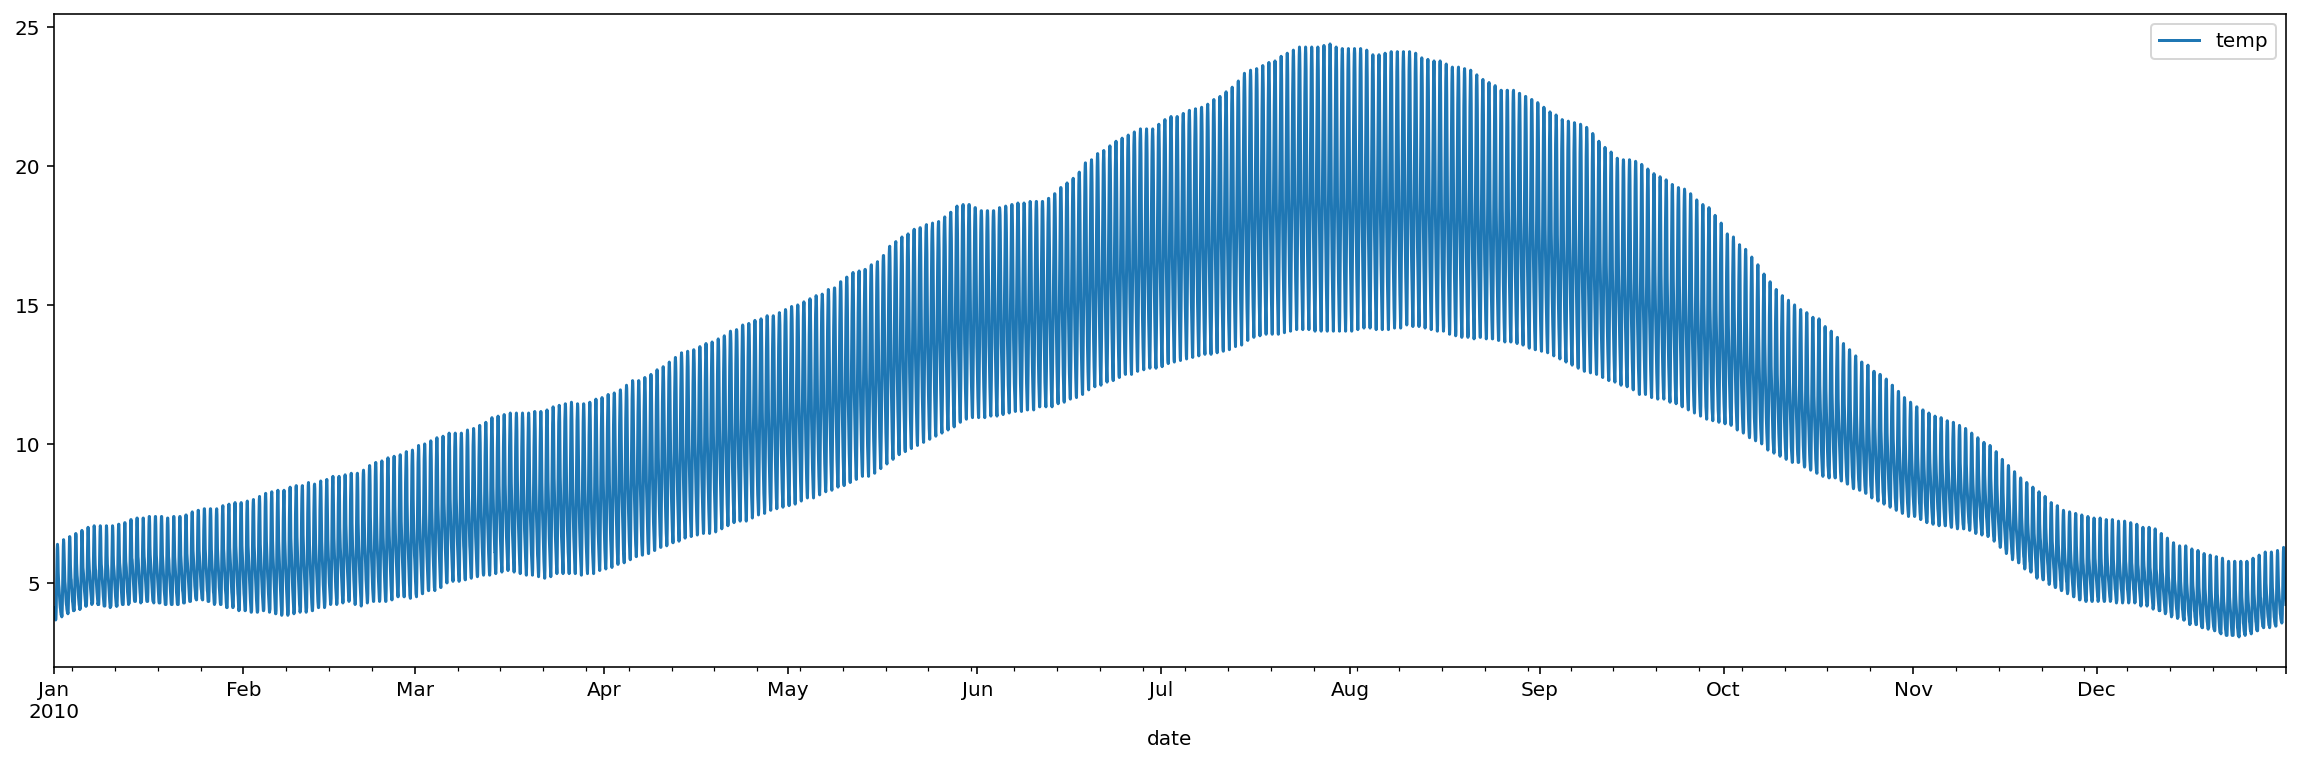

In [7]:
temps.plot(figsize=(20, 6), legend=True)


<AxesSubplot:xlabel='date'>

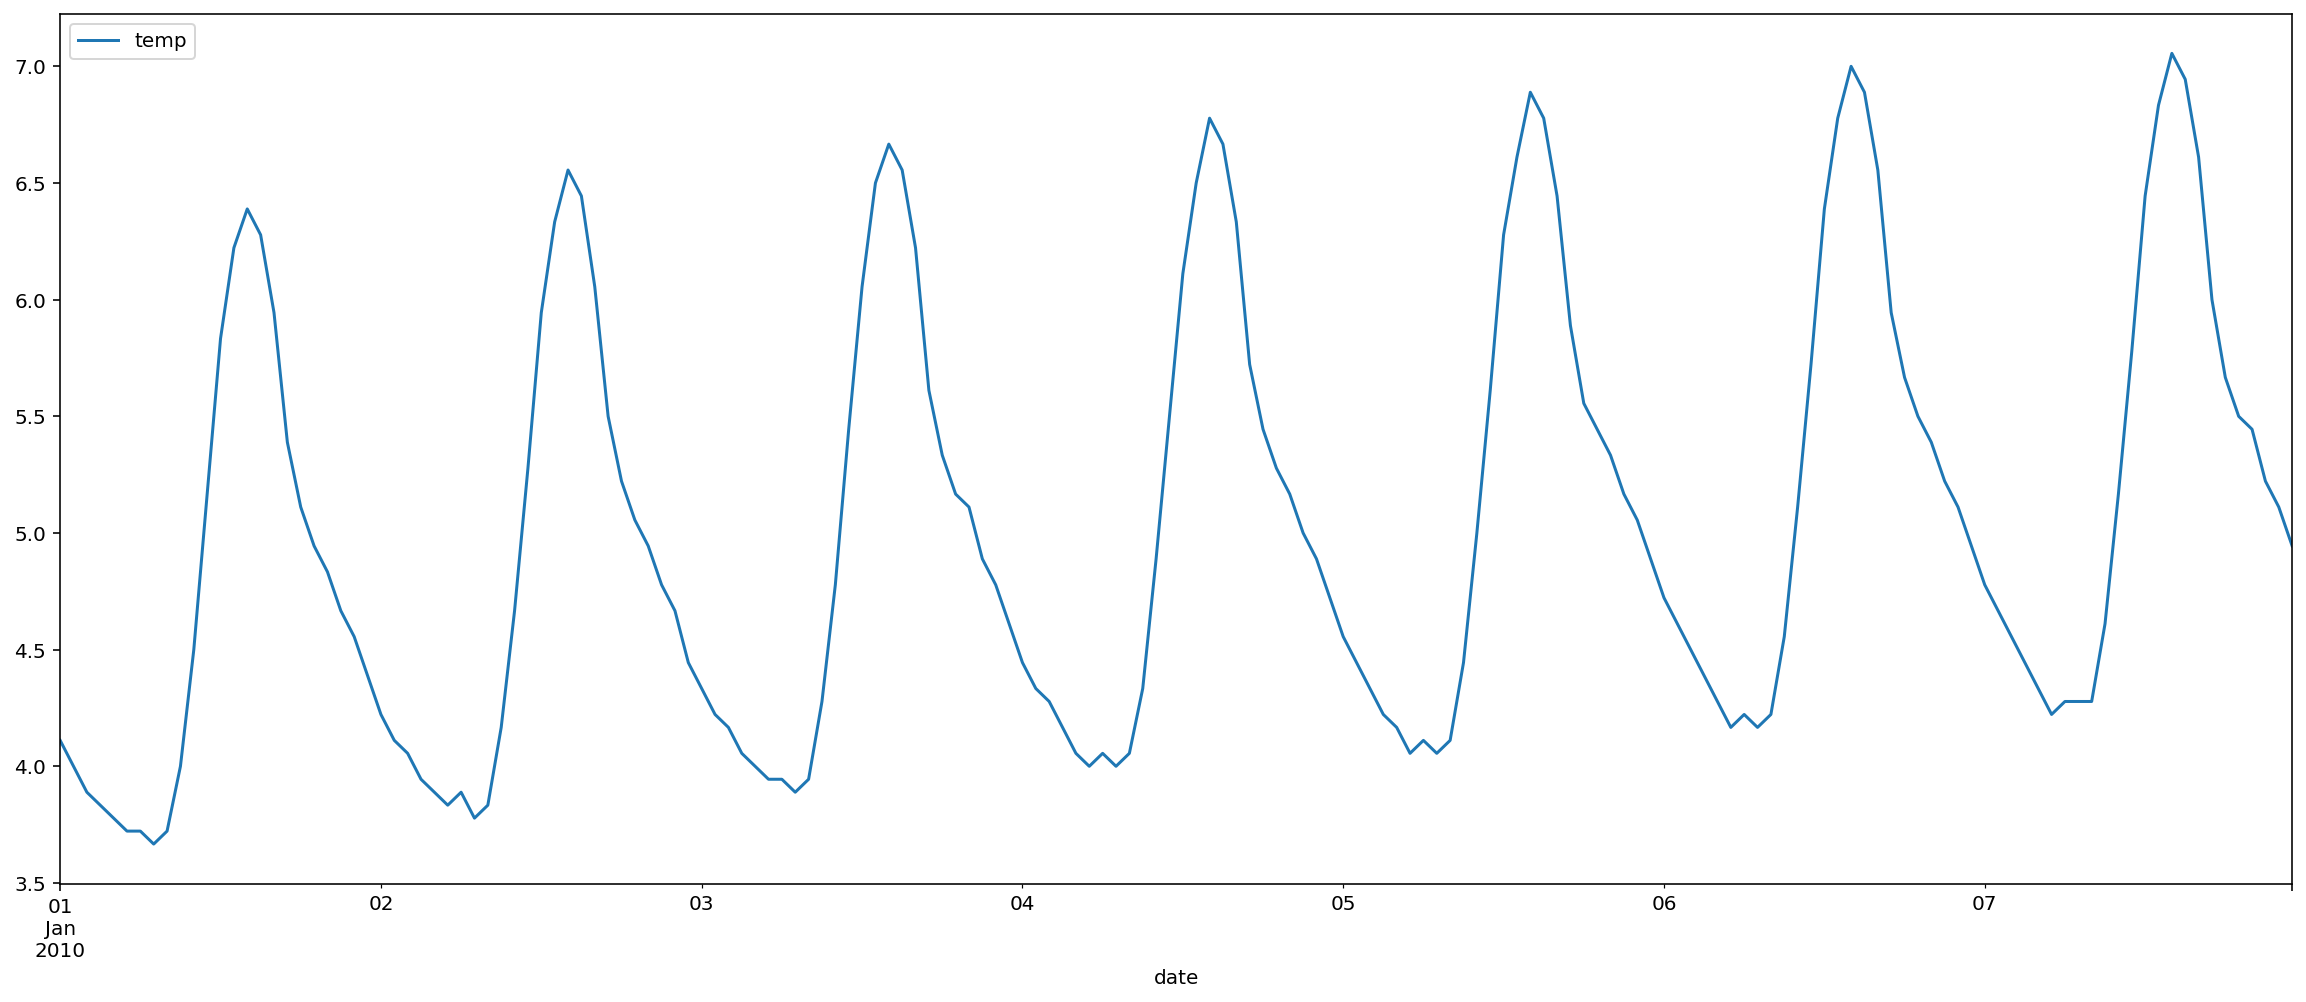

In [8]:
temps.loc[:"2010-01-07"].plot(figsize=(20, 8), legend=True)


<AxesSubplot:xlabel='date'>

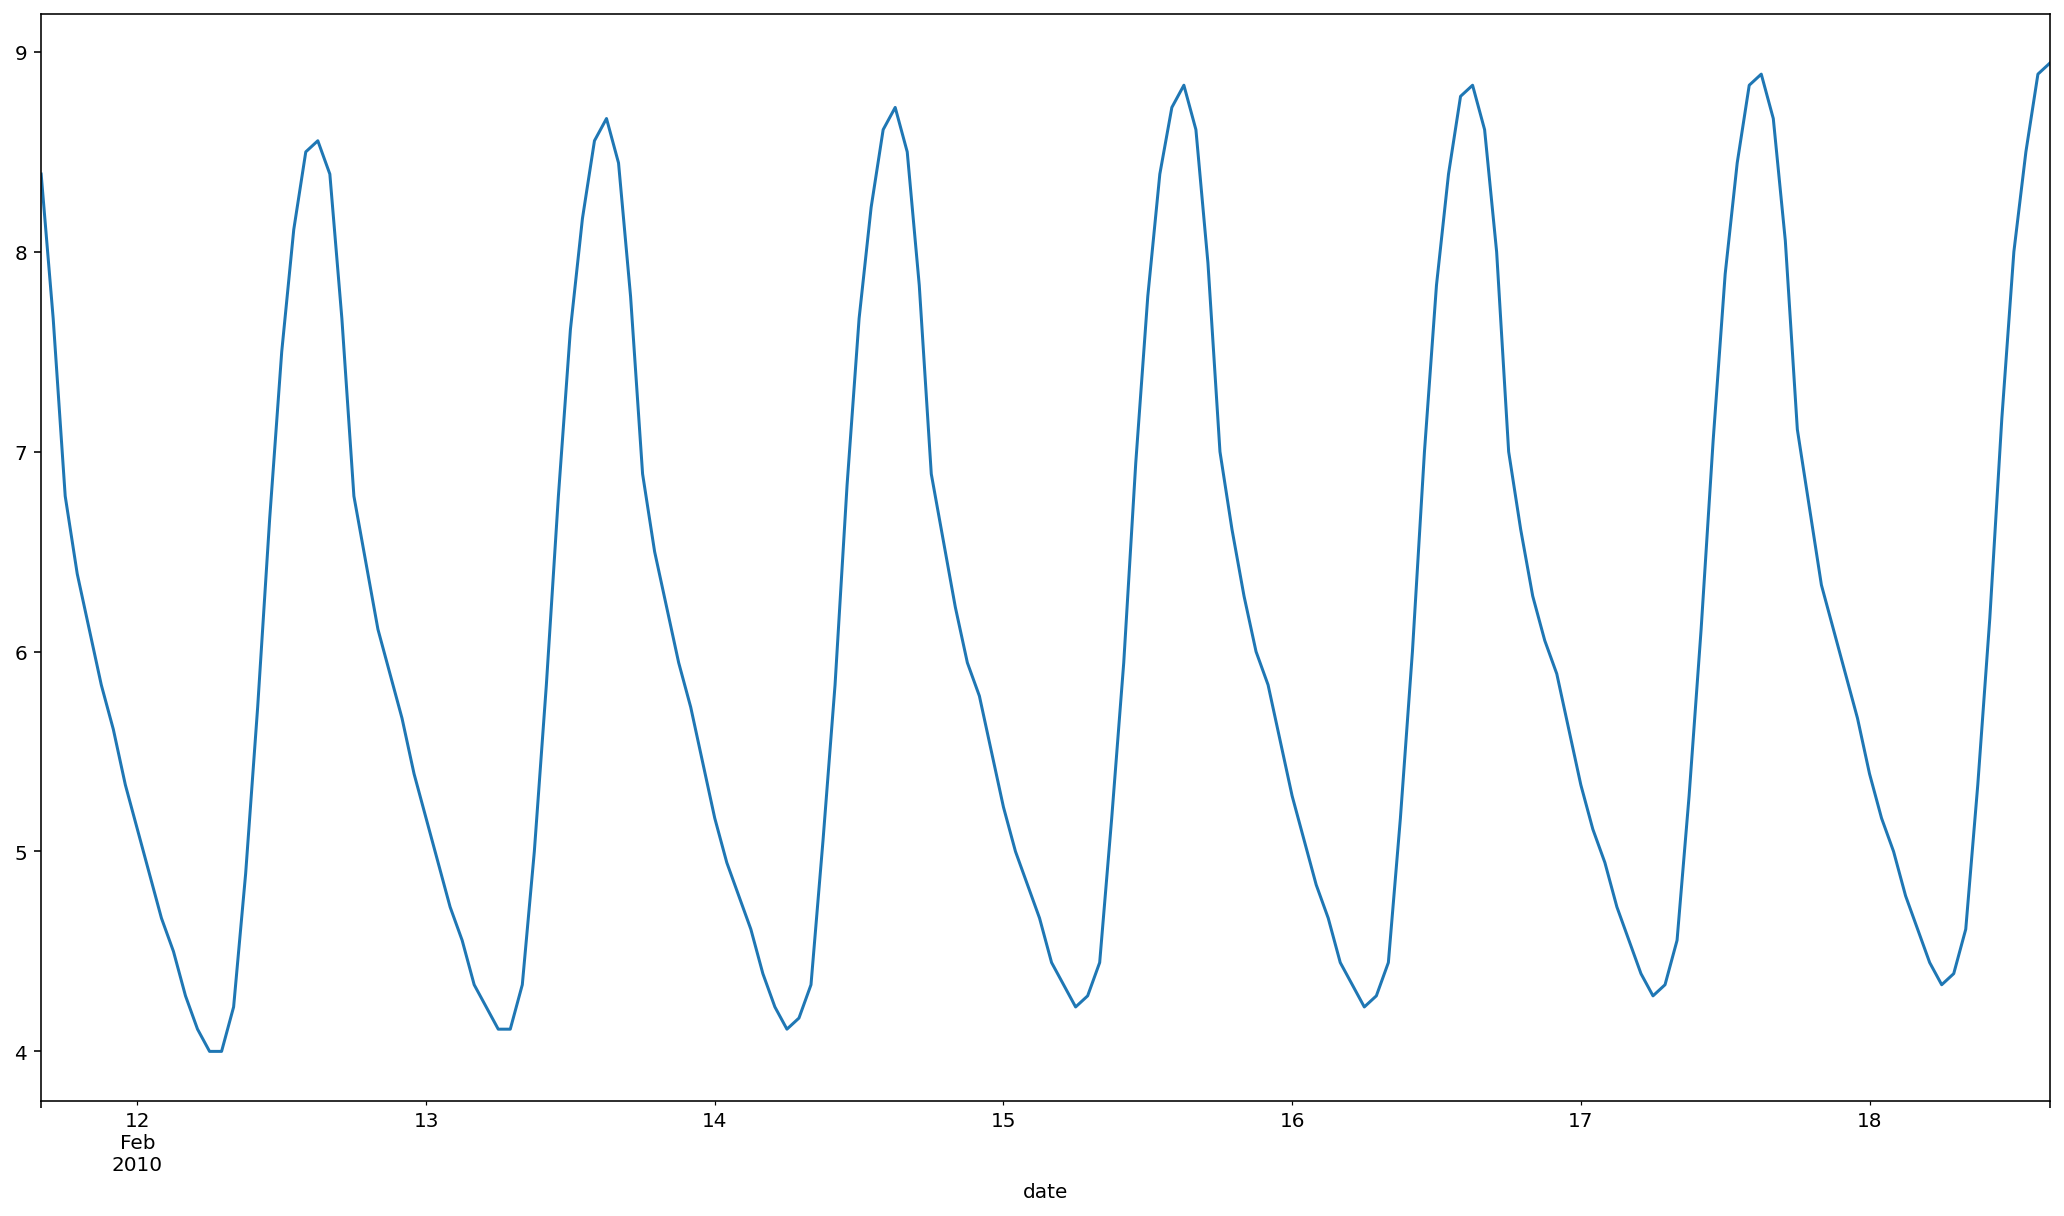

In [9]:
temps.iloc[1000 : 7 * 24 + 1000].plot()


In [10]:
enriched = (
    temps.reset_index()
    .assign(
        dayofyear=lambda f: f["date"].dt.dayofyear,
        hour=lambda f: f["date"].dt.hour,
    )
    .set_index("date")
)

enriched

,temp,dayofyear,hour
date,,,
2010-01-01 00:00:00,4.111111,1,0
2010-01-01 01:00:00,4.000000,1,1
2010-01-01 02:00:00,3.888889,1,2
2010-01-01 03:00:00,3.833333,1,3
2010-01-01 04:00:00,3.777778,1,4
...,...,...,...
2010-12-31 19:00:00,4.833333,365,19
2010-12-31 20:00:00,4.722222,365,20
2010-12-31 21:00:00,4.555556,365,21


In [11]:
trig = enriched.assign(transform="raw").drop("temp", axis=1)
for func in [np.sin, np.cos]:
    new = func(enriched * 2 * np.pi / (enriched.max() + 1)).drop("temp", axis=1)
    trig = pd.concat([trig, new.assign(transform=func.__name__)])

trig = trig.set_index("transform", append=True).rename_axis("features", axis=1)

trig_un = trig.unstack("transform")
trig_un


features            dayofyear                       hour                
transform                 cos    raw       sin       cos   raw       sin
date                                                                    
2010-01-01 00:00:00  0.999853    1.0  0.017166  1.000000   0.0  0.000000
2010-01-01 01:00:00  0.999853    1.0  0.017166  0.965926   1.0  0.258819
2010-01-01 02:00:00  0.999853    1.0  0.017166  0.866025   2.0  0.500000
2010-01-01 03:00:00  0.999853    1.0  0.017166  0.707107   3.0  0.707107
2010-01-01 04:00:00  0.999853    1.0  0.017166  0.500000   4.0  0.866025
...                       ...    ...       ...       ...   ...       ...
2010-12-31 19:00:00  0.999853  365.0 -0.017166  0.258819  19.0 -0.965926
2010-12-31 20:00:00  0.999853  365.0 -0.017166  0.500000  20.0 -0.866025
2010-12-31 21:00:00  0.999853  365.0 -0.017166  0.707107  21.0 -0.707107
2010-12-31 22:00:00  0.999853  365.0 -0.017166  0.866025  22.0 -0.500000
2010-12-31 23:00:00  0.999853  365.0 -0.017166  0.965926  23.0 -0.258819

[8760 rows x 6 columns]

<AxesSubplot:title={'center':'hour'}, xlabel='date'>

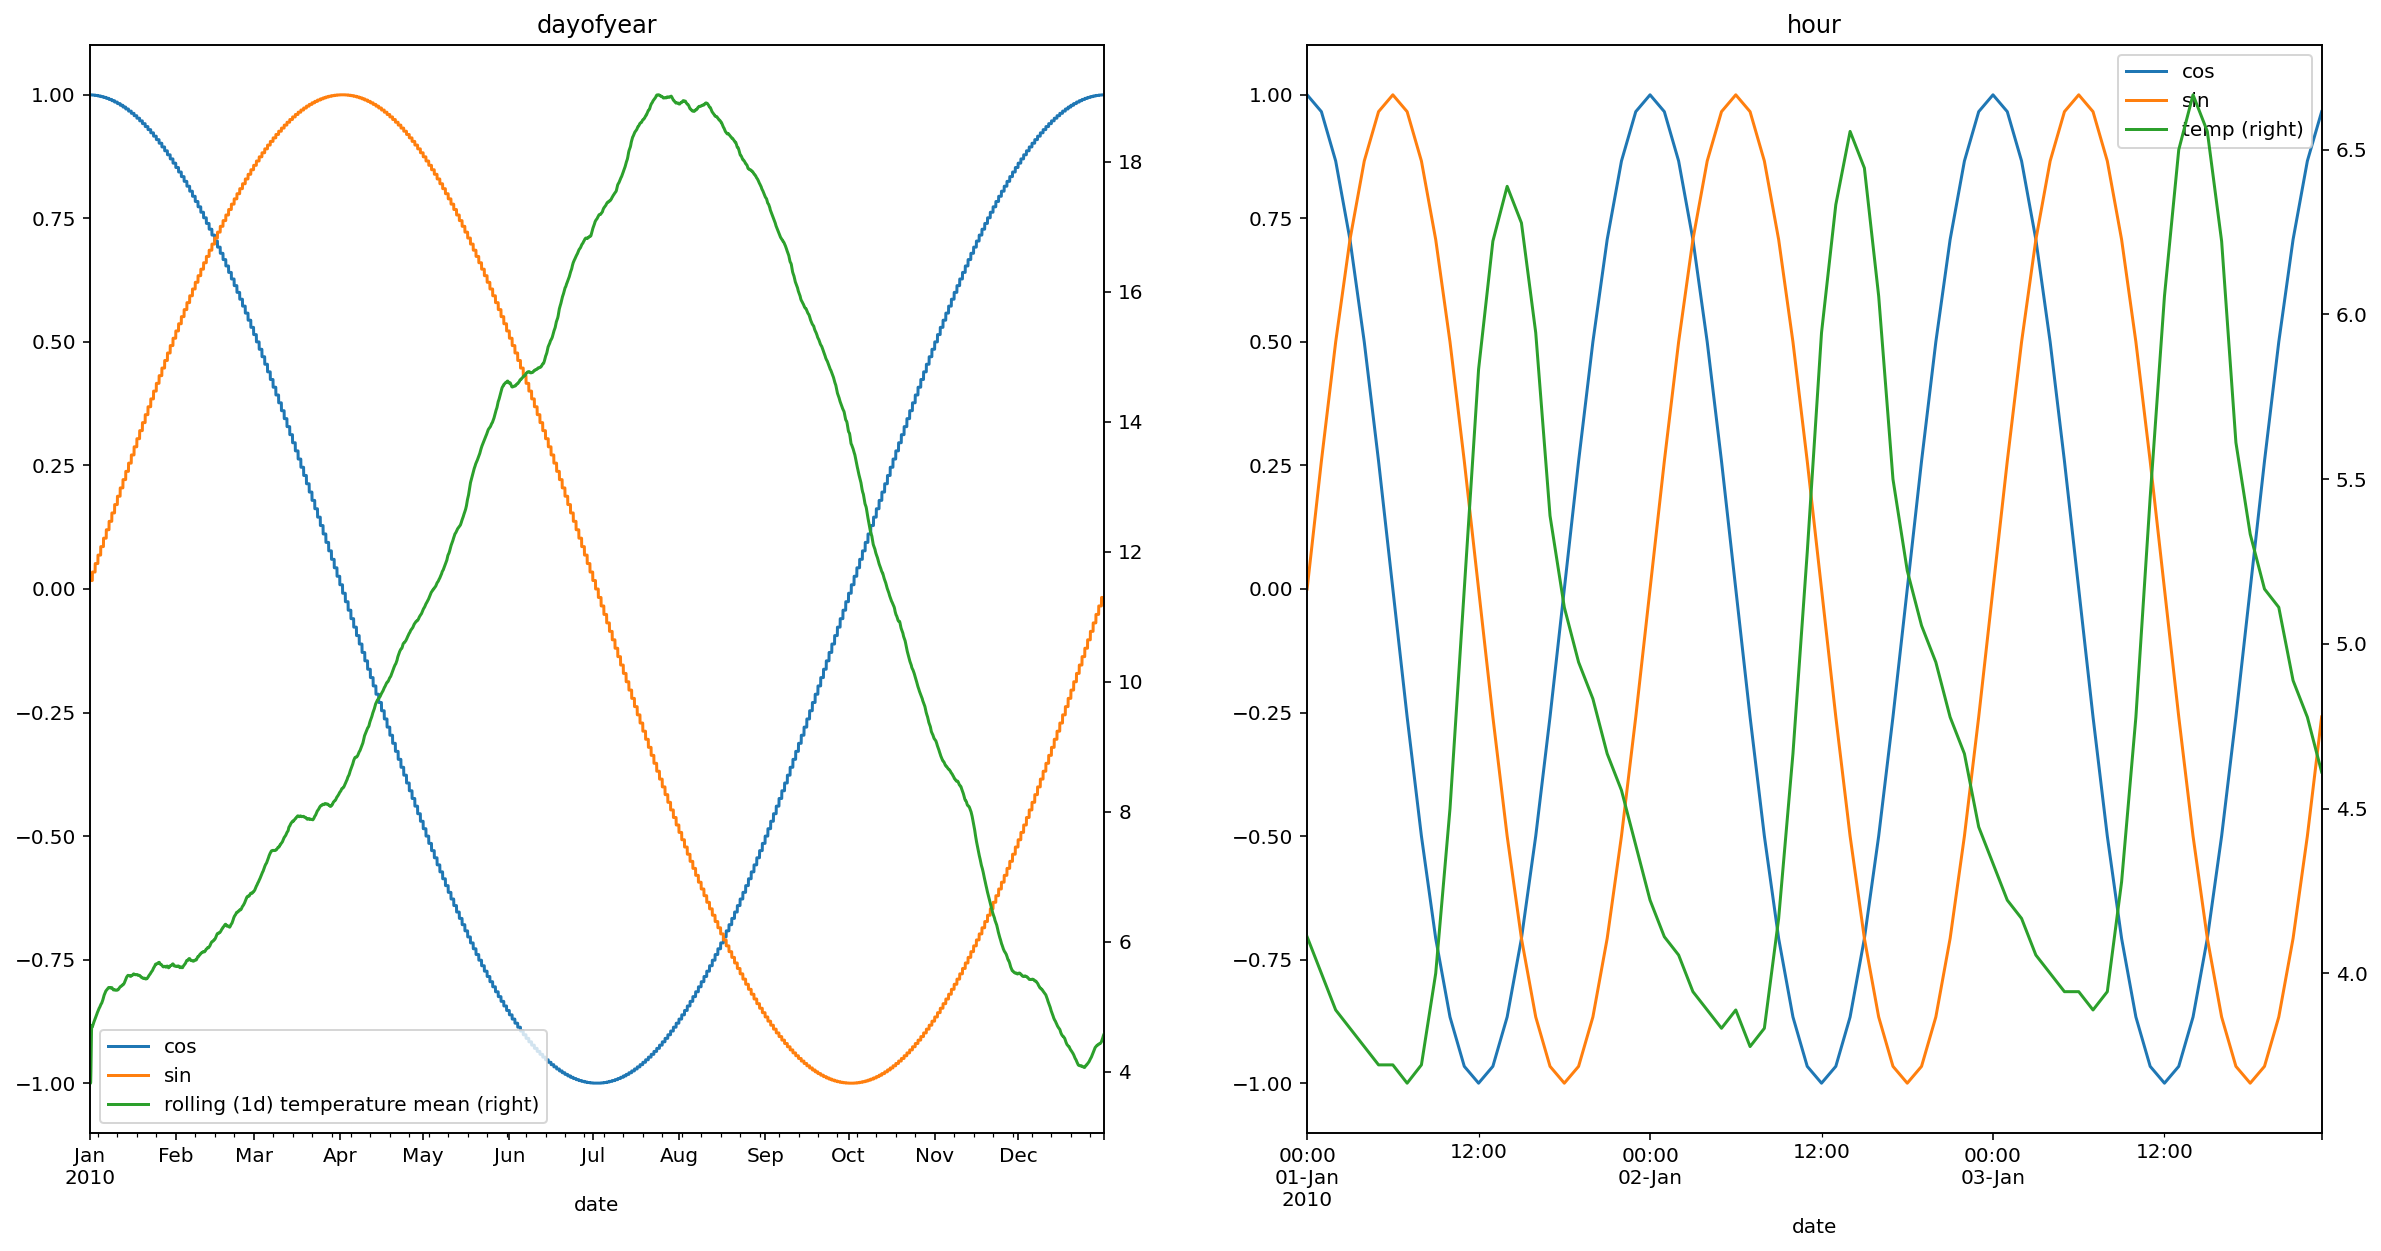

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
ax = ax.reshape(-1)

trig_un.iloc[: 24 * 7 * 365]["dayofyear"][["cos", "sin"]].join(
    enriched["temp"].rolling("1d").mean().rename("rolling (1d) temperature mean")
).plot(title="dayofyear", secondary_y="rolling (1d) temperature mean", ax=ax[0])
trig_un.iloc[: 24 * 3]["hour"][["cos", "sin"]].join(enriched["temp"]).plot(
    title="hour", secondary_y="temp", ax=ax[1]
)


MSE: 0.17354837548238405


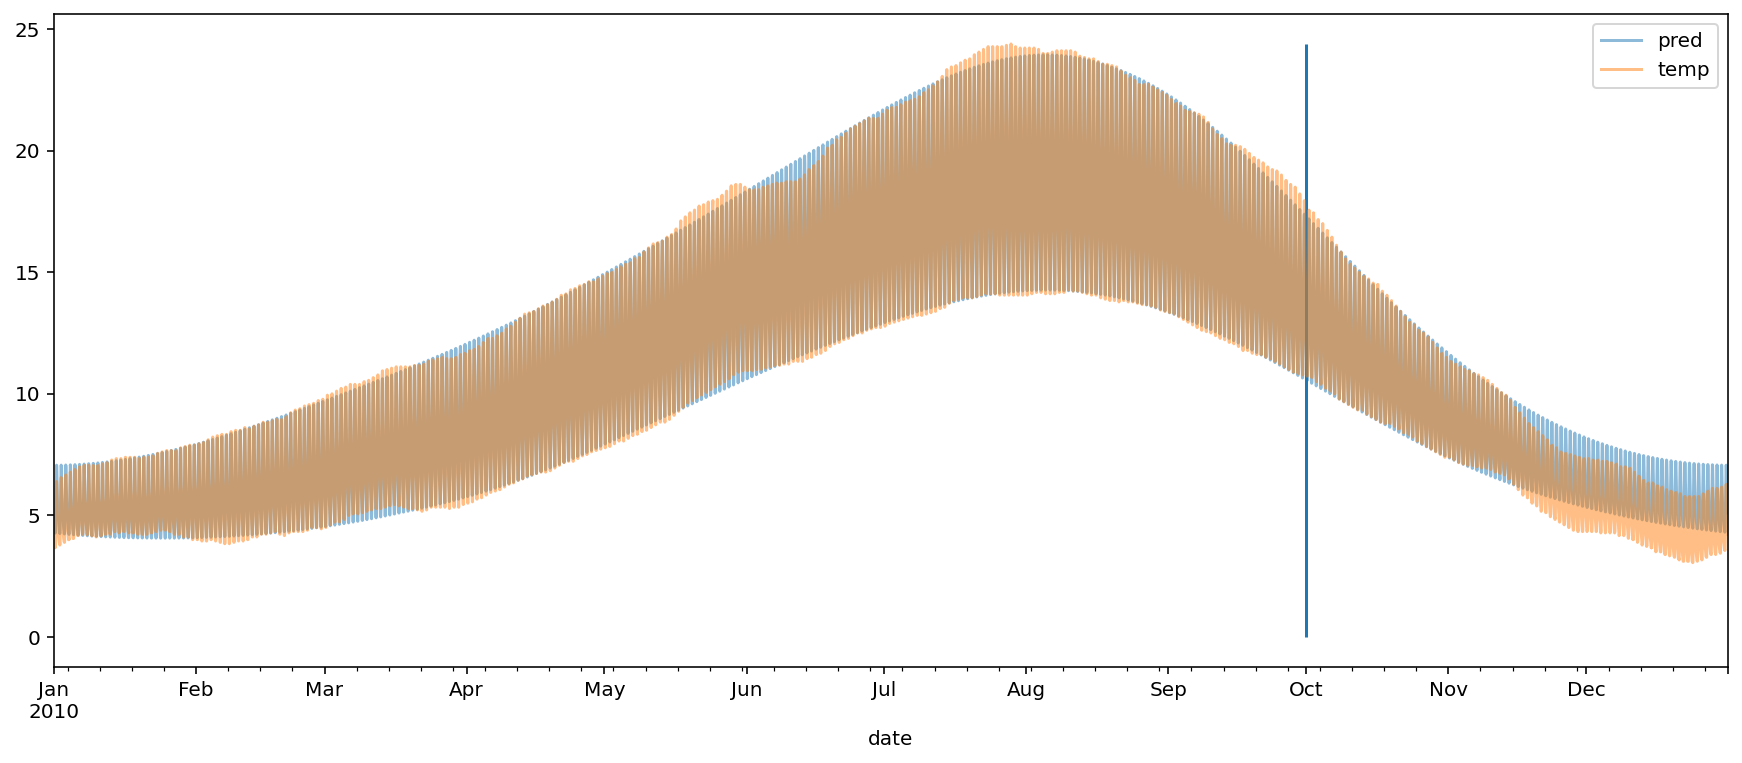

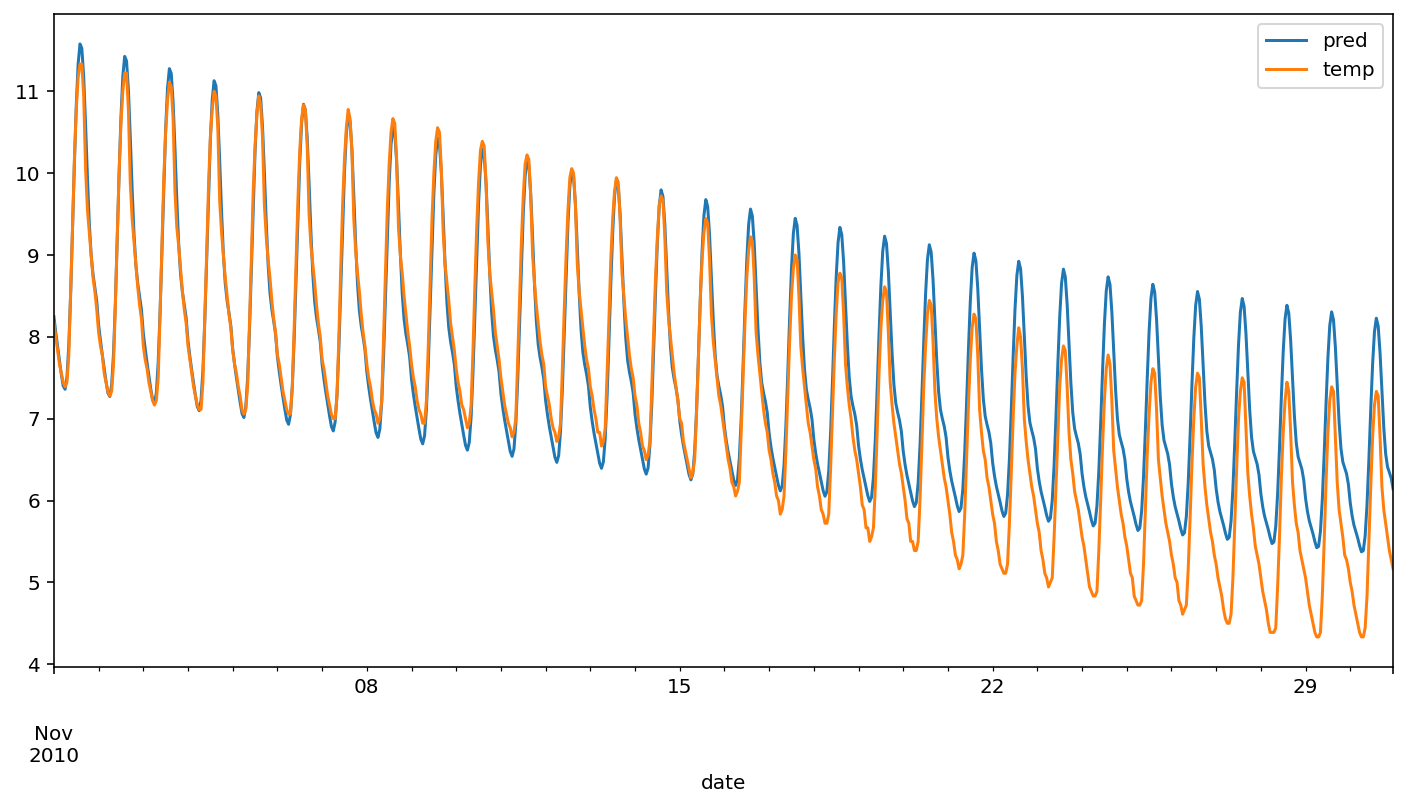

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

X = trig_un.copy()
X.columns = X.columns.map(lambda t: t[0] + "_" + t[1])
X = X.loc[:, lambda f: ~f.columns.str.contains("raw")]

pivot = "october 2010"

# lr = make_pipeline(StandardScaler(), LinearRegression())
lr = make_pipeline(StandardScaler(), SVR())

lr.fit(X.loc[:pivot].sample(1000, random_state=10), temps.loc[:pivot].sample(1000, random_state=10))

pred = pd.Series(lr.predict(X), index=X.index).rename("pred")
pred.plot(legend=True, figsize=(15, 6), alpha=0.5)
temps.plot(legend=True, alpha=0.5)
plt.vlines(pivot, 0, temps.max())


plt.subplots()
pred.loc["november 2010"].plot(legend=True)
temps.loc["november 2010"].plot(legend=True, figsize=(12, 6))
print(f"MSE: {(temps - pred).pow(2).mean()}")

In [14]:
# pd.Series(dict(zip(X.columns, lr.steps[-1][1].coef_))).to_frame(
#     "coef"
# ).style.background_gradient().format("{:.1f}")

In [22]:
fig = bqp.figure()
truth_plot = bqp.plot(temps.index, temps, name="ground truth", opacities=[0.5])
pred_plot = bqp.plot(temps.index, pred, colors=['green'], label="prediction", opacities=[0.5])

pivot = 4000
line = bqp.vline(temps.index[pivot].to_numpy(), stroke_width=2, colors=["orangered"])
line.preserve_domain = dict(x=True, y=True)

bqp.xlabel("time")
bqp.ylabel("temperature")
bqp.legend()

small_fig = bqp.figure()
small_fig.layout.height = "200px"

small_truth_plot = bqp.plot(temps.index, temps, opacities=[0.5])
small_line = bqp.vline(temps.index[pivot].to_numpy(), stroke_width=2, colors=["orangered"])

brushintsel = BrushIntervalSelector(scale=small_truth_plot.scales['x'])
brushintsel.marks = [small_truth_plot]

small_fig.interaction = brushintsel

SEED = 10

def on_pivot_change(change):
    global pred, pivot

    pivot = change['new']
    lr = make_pipeline(StandardScaler(), LinearRegression())
    lr = make_pipeline(StandardScaler(), SVR(C=10, kernel='rbf'))
    # lr = SVR()
    lr.fit(X.iloc[:pivot].sample(100, random_state=10), temps.iloc[:pivot].sample(100, random_state=10))

    pred = pd.Series(lr.predict(X), index=X.index).rename("pred")

    pred_plot.y = pred.loc[begin:end]
    pred_plot.x = temps.loc[begin:end].index
    line.x = [temps.index[pivot].to_numpy()]*2
    small_line.x = [temps.index[pivot].to_numpy()]*2

def on_intsel(change):
    global begin, end
    with debug:
        print(pivot)
        if change["new"] is not None:
            begin, end = brushintsel.selected[0], brushintsel.selected[1]
        else:
            begin, end = temps.index[0].to_numpy(), temps.index[-1].to_numpy()
        
        print("ok")
        
        if temps.index[pivot] < begin or temps.index[pivot] > end:
            line.visible = False
        else:
            line.visible = True
        
        print(pivot, begin, end)
        
        truth_plot.x = temps.loc[begin:end].index.to_numpy()
        truth_plot.y = temps.loc[begin:end]

        pred_plot.x = pred.loc[begin:end].index.to_numpy()
        pred_plot.y = pred.loc[begin:end]

debug = w.Output()
    
begin, end = temps.index[0].to_numpy(), temps.index[-1].to_numpy()
brushintsel.observe(on_intsel, 'selected')
brushintsel.selected = None

pivot_w = w.IntSlider(min=0, max=temps.shape[0] - 1, value=pivot)
pivot_w.observe(on_pivot_change, 'value')
pivot_w.value = 5_000

w.VBox([pivot_w, fig, small_fig])

In [16]:
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskLasso, MultiTaskLassoCV, MultiTaskElasticNetCV

daily_features = trig_un["dayofyear"].assign(dayofyear=lambda f: f["raw"].astype(int)).groupby("dayofyear").first().drop("raw", axis=1).join(enriched.groupby("dayofyear")["temp"].agg(["min", "max"]))

wide_temp = enriched.set_index(["dayofyear", "hour"])["temp"].unstack("hour").fillna(method="ffill")

pivot = "August 2010"

preds, coefs = dict(), dict()
for est in LinearRegression(), MultiTaskElasticNetCV(), MultiTaskLassoCV():
    name = est.__class__.__name__
    lrr = make_pipeline(StandardScaler(), est)
    lrr.fit(daily_features.loc[:pivot], wide_temp.loc[:pivot])
    preds[name] = pd.DataFrame(lrr.predict(daily_features), index=daily_features.index).rename_axis("hour", axis=1).assign(estimator=name).set_index("estimator", append=True).swaplevel()
    coefs[name] = pd.DataFrame(lrr.steps[-1][1].coef_, columns=lrr.feature_names_in_).assign(estimator=name).set_index("estimator", append=True).swaplevel()

In [17]:
pd.concat(coefs.values()).unstack("estimator").style.background_gradient().format("{:.3f}")

<AxesSubplot:xlabel='date'>

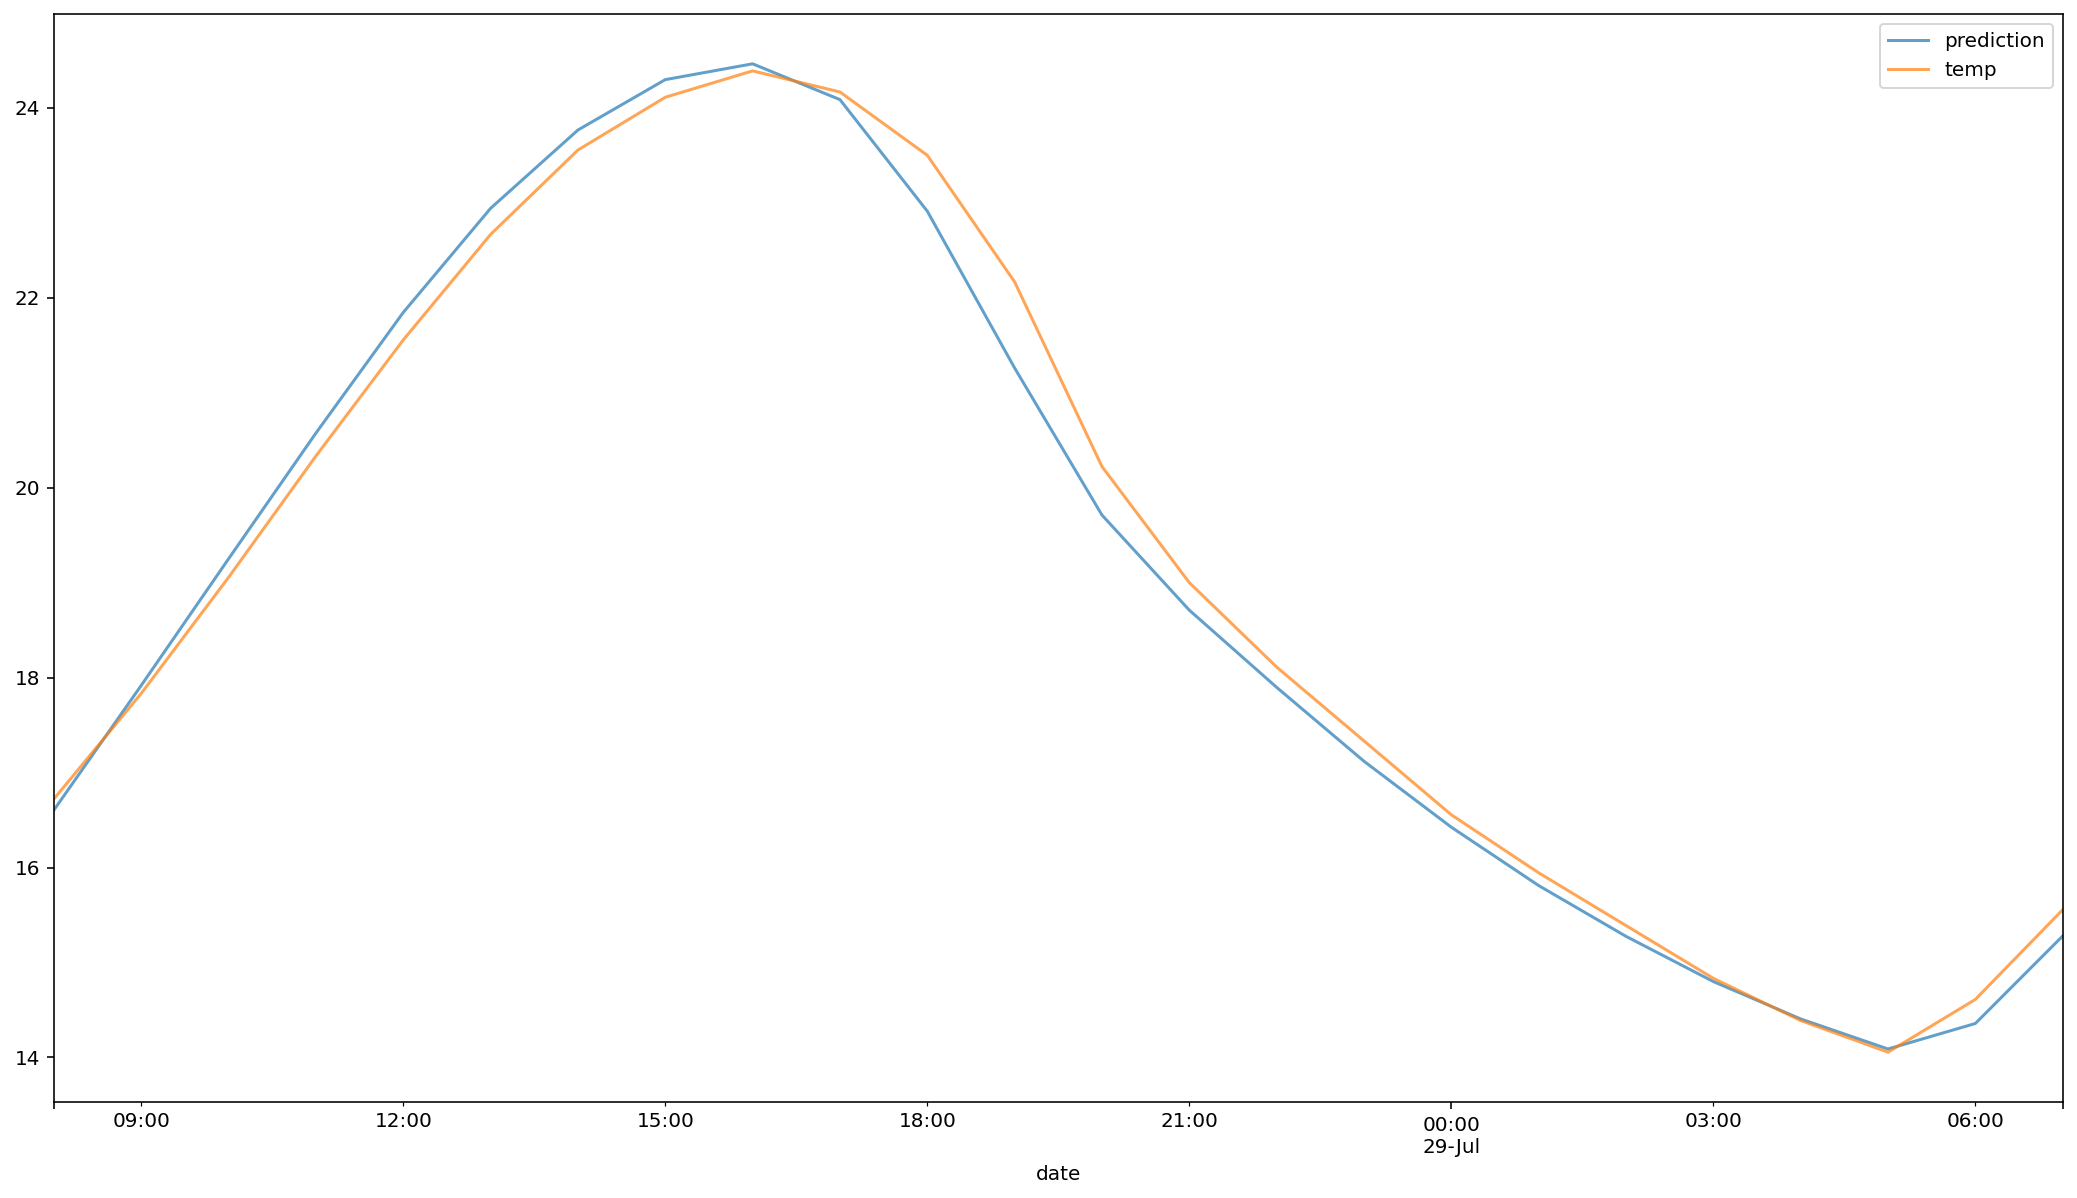

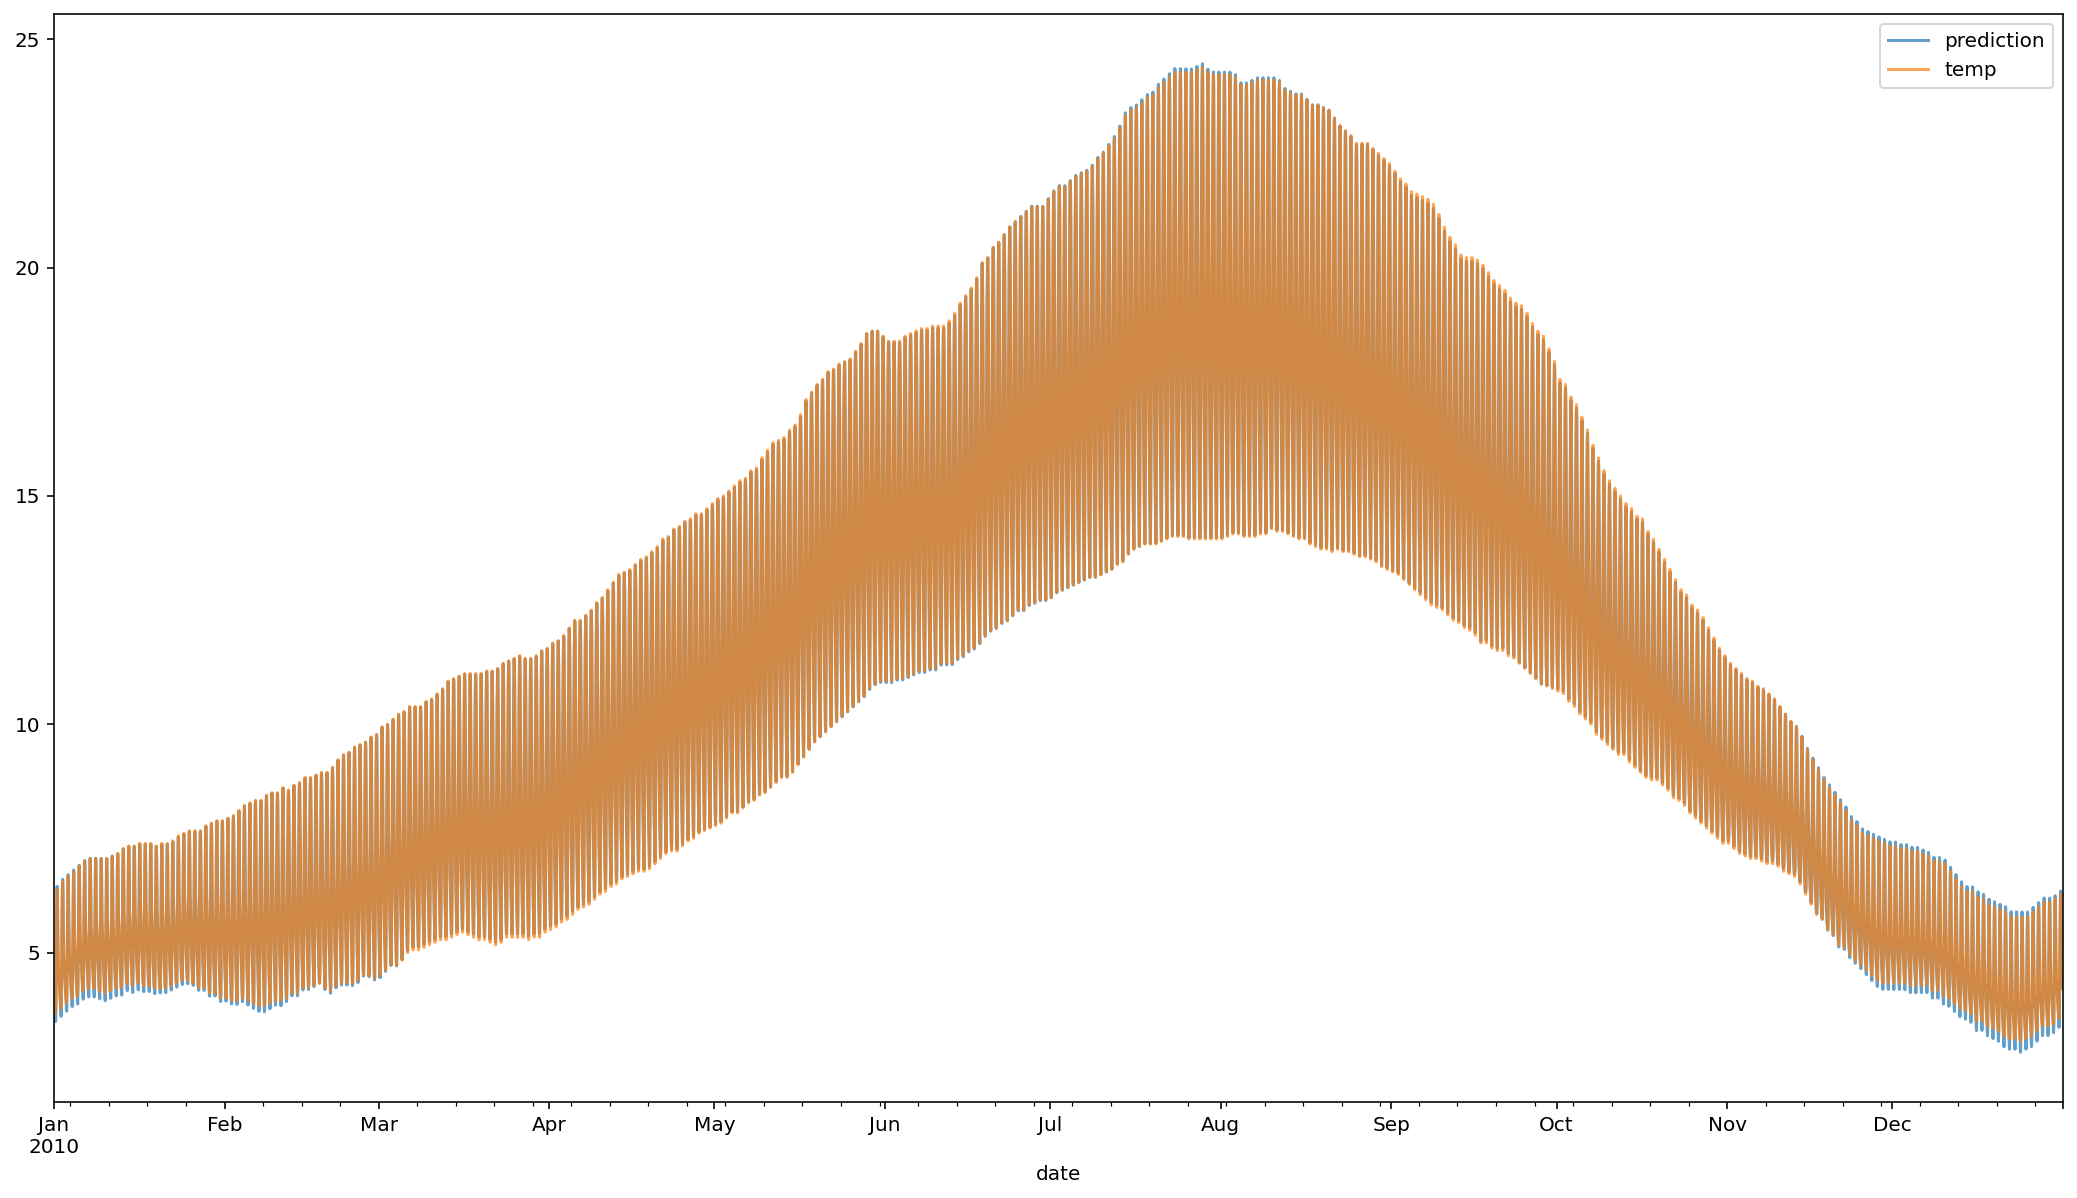

In [18]:
preds_long = preds["LinearRegression"].stack().rename("prediction")
preds_long.index = temps.index
preds_long.iloc[5000:5000+24].to_frame().join(temps).plot(alpha=0.7)

preds_long.to_frame().join(temps).plot(alpha=0.7)

In [20]:
# from scipy.optimize import minimize


# def regressor(x, params):
#     return np.sum(
#         params[2] * np.cos(params[0] * x + params[1]) + params[3]
#         # + params[6] * np.sin(params[4] * x + params[5])
#         ,
#         axis=1,
#     )


# def loss(args):
#     return np.mean(
#         (regressor(enriched[["dayofyear", "hour"]].to_numpy(), args) - temps) ** 2
#     )


# init_params = np.asarray([[2 * np.pi / 365, 2 * np.pi / 24], [1, 1], [1, 1], [1, 1]])
# res = minimize(loss, x0=init_params)
# print(res.x)
# print(res.fun)
# pred_opt = pd.Series(
#     regressor(enriched[["dayofyear", "hour"]].to_numpy(), res.x), index=enriched.index
# )

# pred_opt.plot(figsize=(15, 6))
# temps.plot(alpha=0.5)

# plt.subplots()
# pred_opt.loc[:"2010-01-10"].plot(figsize=(15, 6))
# temps.loc[:"2010-01-10"].plot(alpha=0.5)


In [21]:
# init_params = np.asarray([[2 * np.pi / 365, 2 * np.pi / 24], [1, 1], [10, 5], [10, 10]])
# init_params
